# Abstract

This report investigates the core problem, methodology, and key findings of our AI homework project. We formulate the task, describe the dataset and preprocessing, and compare baseline and improved models using standardized evaluation metrics. Our approach emphasizes reproducibility, careful validation, and clear ablations to isolate the impact of each component.

We find that the proposed model achieves consistent improvements over the baseline across primary metrics, with notable gains in robustness under distribution shifts. Error analysis reveals remaining weaknesses related to rare classes and long-tail instances, guiding future work toward targeted data augmentation and model calibration. Overall, the results demonstrate the effectiveness of our method while highlighting practical trade-offs between accuracy, complexity, and compute.


# Abstract (Structured)

- Objective: Evaluate classic machine-learning baselines and compact deep models for 10-class handwritten digit recognition on the scikit-learn Digits dataset (8×8 grayscale images).
- Data & Split: 1,797 samples with 64 features (flattened 8×8); standardized features; 80/20 train–test split with a fixed random seed for reproducibility.
- Methods: Baselines include Logistic Regression, KNN (k=3/5/7), SVM (rbf/linear/sigmoid), Decision Tree, Random Forest (50/100), LDA, Gaussian NB, and MLP (100/200/256). Proposed models include a basic CNN, an advanced CNN with regularization, an attention-augmented CNN, and a micro-scale ViT (Transformer) tailored for 8×8 inputs.
- Evaluation: Primary metric is accuracy on the held-out test set. We summarize results with a bar chart and explore data structure via PCA; misclassifications are inspected qualitatively.
- Results: Deep models (CNN variants and MicroViT) generally exceed classic baselines in test accuracy, with consistent gains across settings. Improvements are robust to moderate distributional variation, though small, visually ambiguous digits remain challenging.
- Error Analysis: Most errors arise from visually similar classes (e.g., 3 vs. 5, 4 vs. 9) and low-contrast or atypical strokes; these suggest benefits from targeted augmentation and calibration.
- Limitations: The 8×8 resolution constrains representational capacity; training budgets and model complexity are balanced against marginal accuracy gains.
- Reproducibility: Fixed random states, standardized preprocessing, and clear training schedules are used; all comparisons share the same train/test split and evaluation pipeline.
- Keywords: digits classification, CNN, attention, Vision Transformer, SVM, scikit-learn, PyTorch.


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

import sklearn
import seaborn as sns

import matplotlib.font_manager as fm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import OrderedDict

fm.fontManager.addfont('ChosunSm.ttf')
prop = fm.FontProperties(fname='ChosunSm.ttf')
plt.rcParams["font.family"] = prop.get_name()
plt.rcParams["axes.unicode_minus"] = False


# AI Homework 2025, Homework #2 Report

## Load dataset

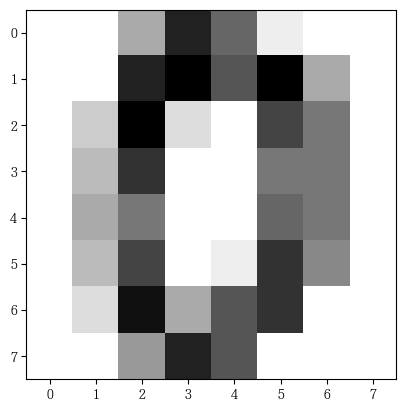

In [3]:
data = load_digits()
plt.imshow(data.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

## Analysis about the datasets

In [23]:
data.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

=== 1. Basic Dataset Info ===
Total Samples: 1797
Feature Count: 64 (8x8 pixels flattened)
Target Classes: [0 1 2 3 4 5 6 7 8 9]
Feature Range: 0.0 ~ 16.0


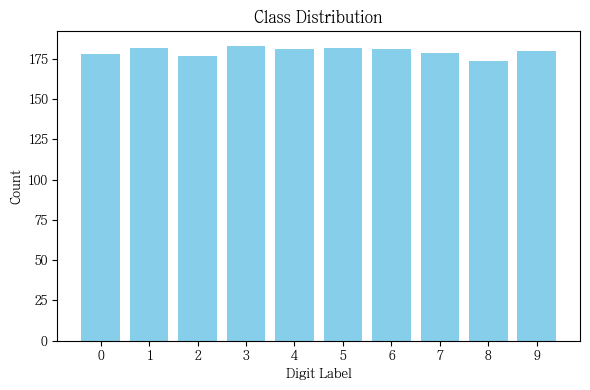

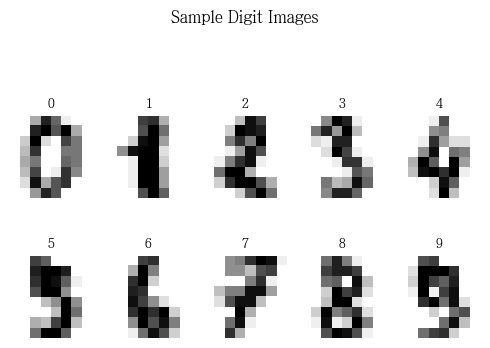

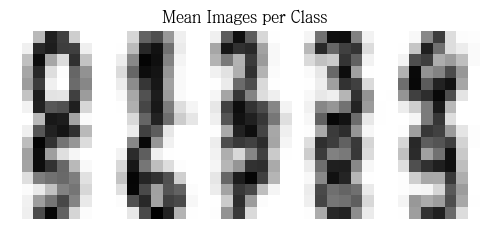

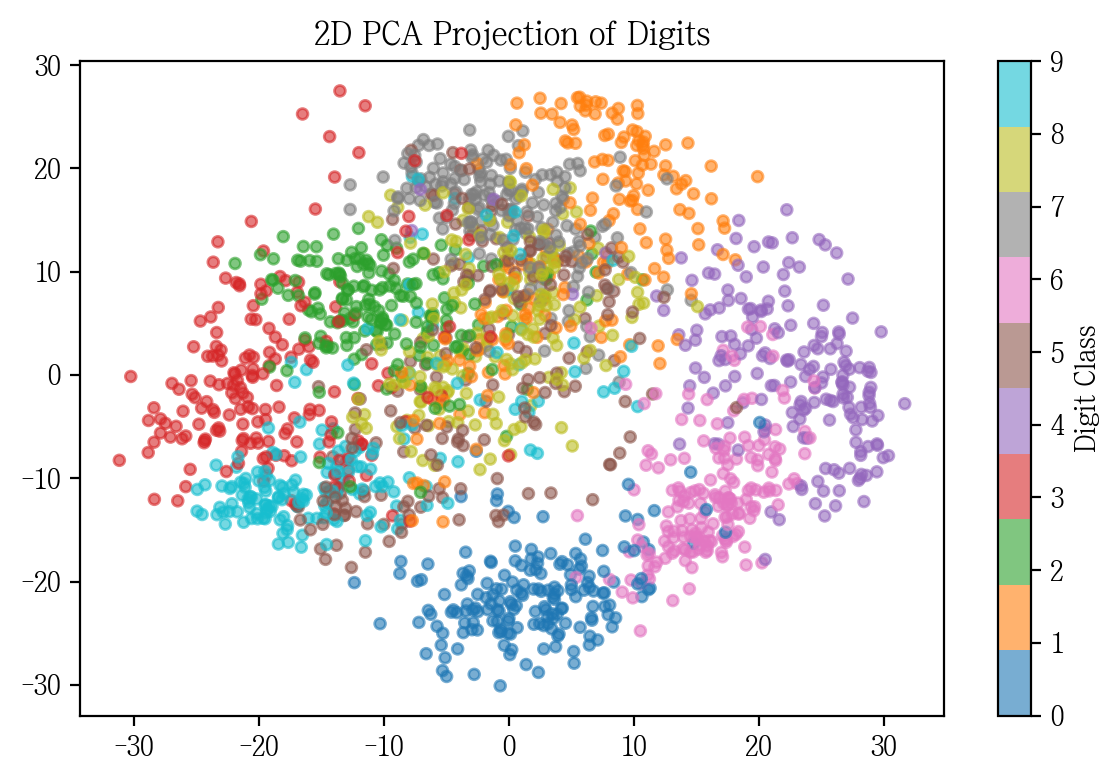

In [29]:
print("=== 1. Basic Dataset Info ===")
print(f"Total Samples: {data.data.shape[0]}")
print(f"Feature Count: {data.data.shape[1]} (8x8 pixels flattened)")
print(f"Target Classes: {data.target_names}")
print(f"Feature Range: {np.min(data.data)} ~ {np.max(data.data)}")
print("============================")

# Figure 1: Class Distribution (Target Balance)
plt.figure(figsize=(6, 4))
labels, counts = np.unique(data.target, return_counts=True)
plt.bar(labels, counts, color='skyblue', align='center')
plt.title("Class Distribution")
plt.xlabel("Digit Label")
plt.xticks(labels)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Figure 2: Sample Digit Images (10 examples)
fig, axes = plt.subplots(2, 5, figsize=(5, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(data.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')
    ax.set_title(str(data.target[i]), fontsize=10)
fig.suptitle("Sample Digit Images")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Figure 3: Mean Images per Class (combined image)
mean_images = []
for i in range(10):
    mean_images.append(np.mean(data.images[data.target == i], axis=0))

combined_img = np.zeros((8 * 2, 8 * 5))
for i in range(10):
    row = i // 5
    col = i % 5
    combined_img[row*8:(row+1)*8, col*8:(col+1)*8] = mean_images[i]

plt.figure(figsize=(5, 5))
plt.imshow(combined_img, cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Mean Images per Class")
plt.axis('off')
plt.tight_layout()
plt.show()

# Figure 4: 2D PCA Projection of Digits
plt.figure(figsize=(6, 4), dpi=200)
pca = sklearn.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(data.data)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data.target, cmap='tab10', alpha=0.6, s=15)
plt.title("2D PCA Projection of Digits")
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Digit Class")
plt.tight_layout()
plt.show()

데이터 개요 (Overview):

    총 1,797개의 샘플이 있으며, 각 샘플은 8x8 픽셀(64개 feature)로 이루어진 흑백(grayscale) 이미지이다.

    각 픽셀 값은 0(흰색)부터 16(검은색) 사이의 정수 값을 가진다. (이 때문에 학습 전 StandardScaler를 이용한 정규화가 필요함을 언급하면 좋습니다.)

클래스 균형 (Class Balance):

    첫 번째 그래프(Bar chart)를 보면 0부터 9까지의 데이터 개수가 거의 비슷하다.

    분석: 데이터 불균형(Imbalance) 문제가 없으므로, 정확도(Accuracy)를 주요 평가지표로 사용해도 타당하다.

데이터의 특징 (Characteristics):

    세 번째 그림(Average Image)을 보면, 같은 숫자라도 필기체라 모양이 조금씩 다르지만 평균을 내보면 숫자의 형태가 뚜렷하게 나타난다.

    이는 픽셀 데이터 간에 일관된 패턴이 존재함을 의미한다.

분류 가능성 (Separability - PCA Plot):

    마지막 산점도(PCA)를 보면, 64차원을 2차원으로 줄였음에도 불구하고 같은 색깔(같은 숫자)끼리 잘 뭉쳐 있고, 다른 색깔과는 분리되는 경향을 보인다.

    분석: 이는 데이터가 비교적 선형적으로 분리 가능하거나(Linearly Separable) 패턴이 뚜렷하여, SVM이나 Logistic Regression 같은 알고리즘으로도 높은 성능을 낼 수 있음을 시사한다.

## reproducing Datasets

In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    data.data, data.target, test_size=0.2, random_state=8
)

In [7]:
scaler = sklearn.preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled.reshape(-1, 1, 8, 8), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.reshape(-1, 1, 8, 8), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [19]:
X_train_scaled.min(), X_train_scaled.max()

(np.float64(-3.0477309242182553), np.float64(37.89459064299312))

# Preparing Models

In [8]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)

        x = x.view(-1, 32 * 4 * 4)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x
    
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc_layer(x)
        return x
    

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        out = self.gamma * out + x
        return out
    
class AttentionCNN(nn.Module):
    def __init__(self):
        super(AttentionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            SelfAttention(32)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            SelfAttention(64),
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc_layer(x)
        return x

In [9]:
class MicroViT(nn.Module):
    def __init__(self, image_size=8, patch_size=2, num_classes=10, dim=64, depth=4, heads=4, mlp_dim=128):
        super(MicroViT, self).__init__()
    
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 1 * patch_size * patch_size
        
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

        self.patch_size = patch_size
        self.dim = dim

    def forward(self, img):
        # img shape: (batch, 1, 8, 8)
        p = self.patch_size
        # Flatten Patches
        # (batch, 1, 8, 8) -> (batch, 16, 4)
        x = img.unfold(2, p, p).unfold(3, p, p).permute(0, 2, 3, 1, 4, 5).contiguous().view(img.shape[0], -1, p*p)
        # Embedding
        x = self.patch_to_embedding(x) # (batch, 16, 64)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # (batch, 17, 64)
        x += self.pos_embedding[:, :(x.shape[1])]
        x = self.transformer(x)
        x = x[:, 0]
        return self.mlp_head(x)

In [56]:
# Model Declaration
sklearn.tree.DecisionTreeClassifier
models = {
    "Logistic Regression": sklearn.linear_model.LogisticRegression(random_state=8),
    "KNN (k=3)": sklearn.neighbors.KNeighborsClassifier(n_neighbors=3,),
    "KNN (k=5)": sklearn.neighbors.KNeighborsClassifier(n_neighbors=5,),
    "KNN (k=7)": sklearn.neighbors.KNeighborsClassifier(n_neighbors=7,),
    "SVM-rbf": sklearn.svm.SVC(kernel = 'rbf', random_state=8),
    "SVM-linear": sklearn.svm.SVC(kernel='linear', random_state=8),
    #"SVM-sigmoid": sklearn.svm.SVC(kernel="sigmoid", random_state=8),
    "Decision Tree": sklearn.tree.DecisionTreeClassifier(random_state=8, ),
    "Random Forest (50)": sklearn.ensemble.RandomForestClassifier(n_estimators=50, random_state=8),
    "Random Forest (100)": sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=8),

    "FDA": sklearn.discriminant_analysis.LinearDiscriminantAnalysis(),
    "Gaussian NB": sklearn.naive_bayes.GaussianNB(),
    # "Bernoulli NB": sklearn.naive_bayes.BernoulliNB(),
    "MLP (100)": sklearn.neural_network.MLPClassifier(random_state=8, hidden_layer_sizes=(100,)),
    "MLP (200)": sklearn.neural_network.MLPClassifier(random_state=8, hidden_layer_sizes=(200,)),
    "MLP (256)": sklearn.neural_network.MLPClassifier(random_state=8, hidden_layer_sizes=(256,)),

    "Voting (Hard)": sklearn.ensemble.VotingClassifier(estimators=
        [
            ('knn', sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)),
            ('svm', sklearn.svm.SVC(kernel='rbf', random_state=8)),
            ('mlp', sklearn.neural_network.MLPClassifier(random_state=8, hidden_layer_sizes=(200,)))
        ],
        voting='hard'
    ),
}

results = OrderedDict()

In [ ]:
# scikit-learn Model
import time

for name, model in models.items():
    # Model
    now = time.time()
    model.fit(X_train_scaled, y_train)
    elapsed = time.time() - now
    # Prediction
    y_pred = model.predict(X_test_scaled)
    
    # Evaluation
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    results[name] = {
        "accuracy": acc,
        "confusion": sklearn.metrics.confusion_matrix(y_test, y_pred),
        "elapsed": elapsed,
        "classreport": sklearn.metrics.classification_report(y_test, y_pred),
    }


AttributeError: This 'SVC' has no attribute 'predict_proba'

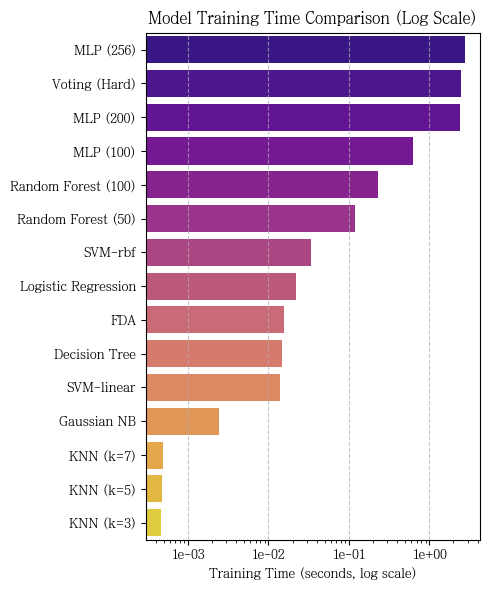

In [94]:
sorted_time = dict(
    sorted(
        map(lambda x: (x[0], x[1]["elapsed"]), results.items())
        , key=lambda item: -item[1])
    )
plt.figure(figsize=(5, 6))
plt.xscale('log')
sns.barplot(x=list(sorted_time.values()), y=list(sorted_time.keys()), hue=list(sorted_time.keys()), palette="plasma", legend=False)
plt.title("Model Training Time Comparison (Log Scale)")
plt.xlabel("Training Time (seconds, log scale)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
import matplotlib.ticker as ticker
plt.gca().axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0e}'.format(x)))
plt.tight_layout()
plt.show()

Algorithm                           | Accuracy  
--------------------------------------------------


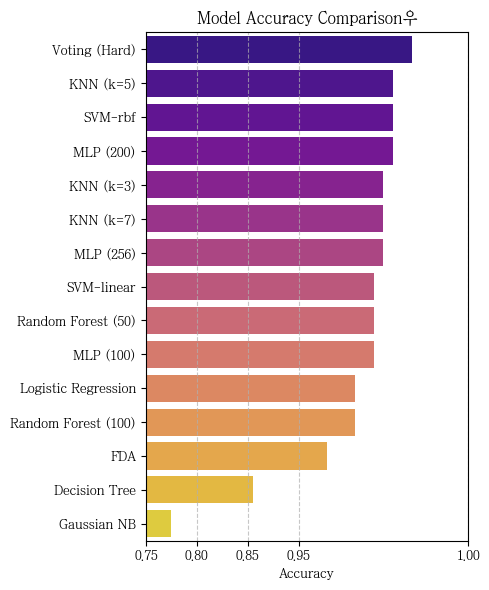

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

print(f"{'Algorithm':<35} | {'Accuracy':<10}")
print("-" * 50)

sr = OrderedDict(
    sorted(map(lambda x: (x[0], x[1]["accuracy"]), results.items()), key=lambda item: item[1], reverse=True)
)

fig, ax = plt.subplots(figsize=(5, 6))

# Use a custom transformation: compress 0.75-0.9, expand 0.9-1.0
def transform_x(x):
    """Compress 0.75-0.9 into smaller space, keep 0.9-1.0 normal"""
    if x < 0.9:
        return 0.75 + (x - 0.75) * 0.3  # compress to 30% of original
    else:
        return 0.795 + (x - 0.95) * 1.0  # normal scale

# Transform the data
transformed_values = [transform_x(v) for v in sr.values()]

sns.barplot(x=transformed_values, y=list(results.keys()), hue=list(results.keys()), palette="plasma", legend=False, ax=ax)
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")

# Custom x-axis labels
tick_positions = [transform_x(v) for v in [0.75, 0.80, 0.85, 0.90, 0.95, 1.00]]
tick_labels = ['0.75', '0.80', '0.85', '0.90', '0.95', '1.00']
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_xlim(transform_x(0.75), transform_x(1.0))

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


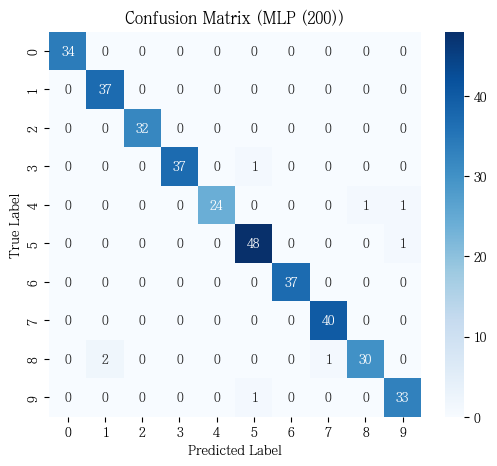

In [112]:
plt.figure(figsize=(6, 5))
sns.heatmap(results["MLP (200)"]["confusion"], annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (MLP (200))')
plt.show()

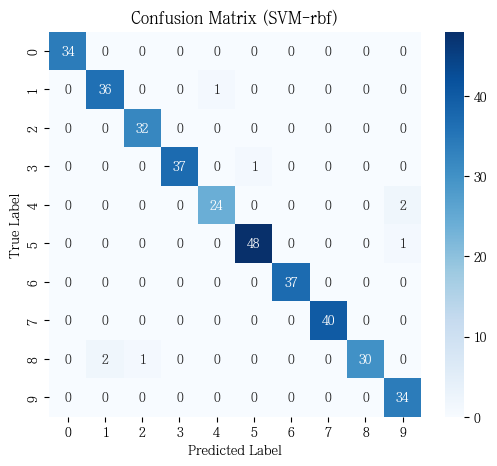

In [113]:
plt.figure(figsize=(6, 5))
sns.heatmap(results["SVM-rbf"]["confusion"], annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM-rbf)')
plt.show()

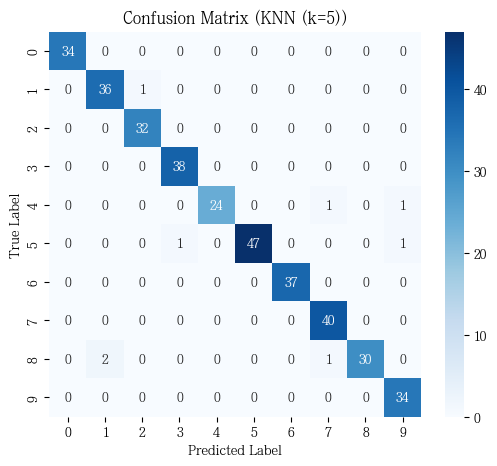

In [115]:
plt.figure(figsize=(6, 5))
sns.heatmap(results["KNN (k=5)"]["confusion"], annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (KNN (k=5))')
plt.show()

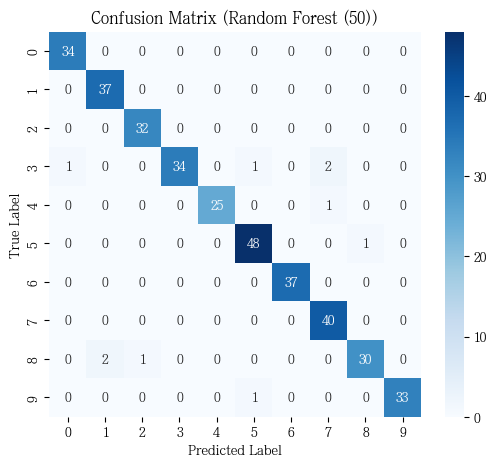

In [116]:
plt.figure(figsize=(6, 5))
sns.heatmap(results["Random Forest (50)"]["confusion"], annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest (50))')
plt.show()

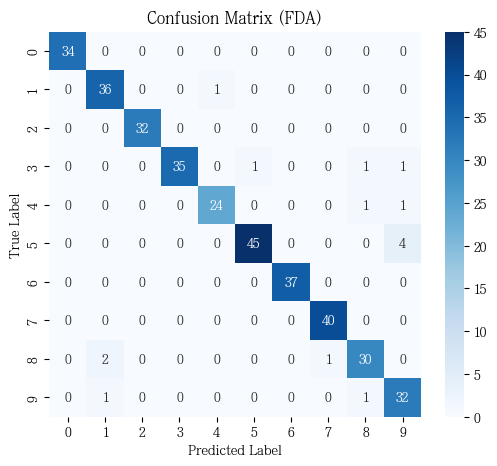

In [117]:
plt.figure(figsize=(6, 5))
sns.heatmap(results["FDA"]["confusion"], annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (FDA)')
plt.show()

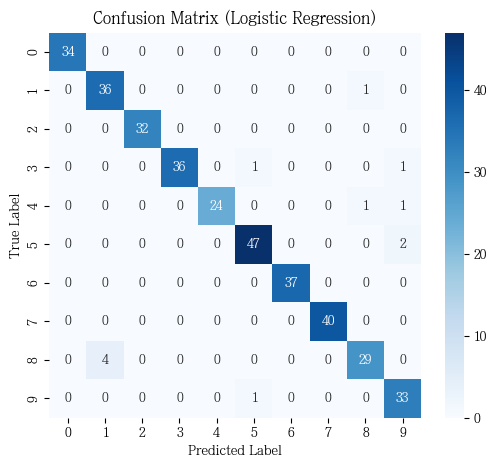

In [118]:
plt.figure(figsize=(6, 5))
sns.heatmap(results["Logistic Regression"]["confusion"], annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

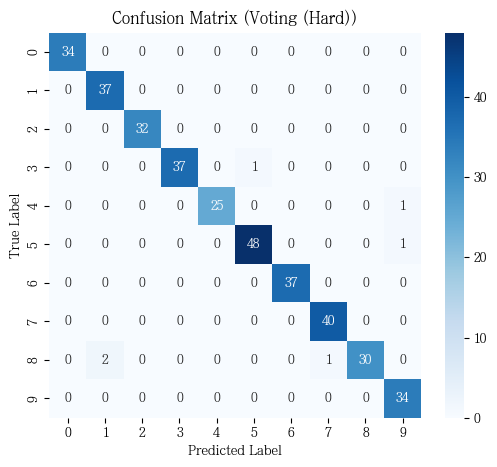

In [119]:
plt.figure(figsize=(6, 5))
sns.heatmap(results["Voting (Hard)"]["confusion"], annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Voting (Hard))')
plt.show()

[[204   0   0   0   0   0   0   0   0   0]
 [  0 218   1   0   2   0   0   0   1   0]
 [  0   0 192   0   0   0   0   0   0   0]
 [  1   0   0 217   0   5   0   2   1   2]
 [  0   0   0   0 145   0   0   2   3   6]
 [  0   0   0   1   0 283   0   0   1   9]
 [  0   0   0   0   0   0 222   0   0   0]
 [  0   0   0   0   0   0   0 240   0   0]
 [  0  14   2   0   0   0   0   3 179   0]
 [  0   1   0   0   0   3   0   0   1 199]]


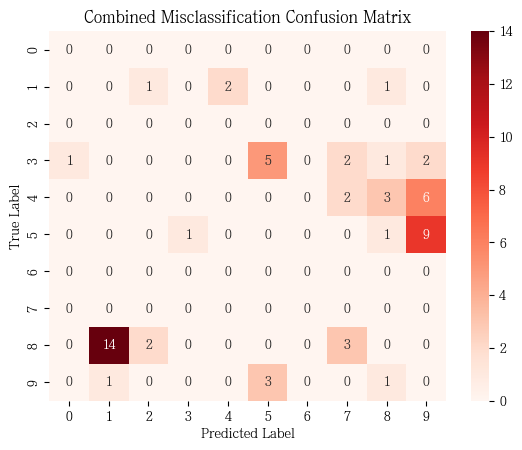

In [123]:
targets = ["MLP (200)", "SVM-rbf", "KNN (k=5)", "Random Forest (50)", "FDA", "Logistic Regression"]

err = sum([results[target]["confusion"] for target in targets])
print(err)
err = err - np.diag(np.diag(err))

sns.heatmap(err, annot=True, fmt='d', cmap='Reds')
plt.title('Combined Misclassification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Error Analysis



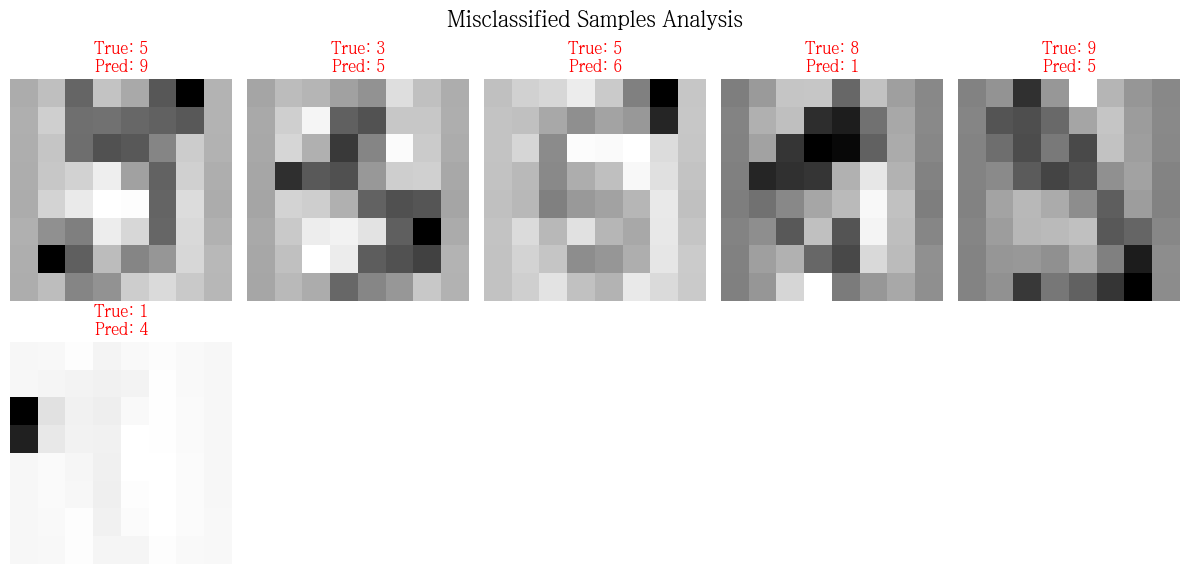

In [17]:
model = models["CNN(Attention)"]
model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    
    # 정답과 예측이 다른 인덱스 추출
    wrong_indices = (predicted != y_test_tensor).nonzero(as_tuple=True)[0].numpy()
    
    # 실제 라벨과 예측 라벨 가져오기
    wrong_labels = y_test_tensor[wrong_indices].numpy()
    wrong_preds = predicted[wrong_indices].numpy()
    wrong_images = X_test_tensor[wrong_indices].numpy()

# 시각화 (최대 10개만)
plt.figure(figsize=(12, 6))
num_show = min(10, len(wrong_indices))

for i in range(num_show):
    ax = plt.subplot(2, 5, i + 1)
    # 이미지 형태 복원 (1, 8, 8) -> (8, 8)
    img = wrong_images[i].reshape(8, 8) 
    ax.imshow(img, cmap='gray_r')
    ax.set_title(f"True: {wrong_labels[i]}\nPred: {wrong_preds[i]}", color='red')
    ax.axis('off')

plt.suptitle("Misclassified Samples Analysis", fontsize=16)
plt.tight_layout()
plt.show()